In [1]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import *
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy import signal
import timm
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

In [2]:
class CFG:
    seed = 42  # Random seed for reproducibility
    debug = False  # Debug mode for faster iteration
    apex = False  # Use NVIDIA Apex for mixed precision training
    print_freq = 100  # Logging frequency (batches)
    num_workers = 2  # Number of dataloader subprocesses

    # File and directory paths
    OUTPUT_DIR = '/kaggle/working/'  # Directory to save outputs and models
    train_datadir = '/kaggle/input/birdclef-2025/train_audio'  # Path to training audio
    train_csv = '/kaggle/input/birdclef-2025/train.csv'  # Training metadata CSV
    test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'  # Test soundscape audio
    submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'  # Sample submission format
    taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'  # Bird species taxonomy information

    spectrogram_npy = '/kaggle/input/dataset/birdclef2025_mfccspec_5sec_256_256.npy'  # Cached mfcc spectrograms (optional)

    # Model configuration
    model_name = 'efficientnet_b0'  # Backbone model architecture
    model_path = '/kaggle/working/'  # Path to save/load model checkpoints
    pretrained = True  # Use pretrained weights
    in_channels = 1  # Number of input channels (e.g., 1 for mfcc-spectrograms)

    # Audio preprocessing
    LOAD_DATA = True  # Whether to load and preprocess audio data
    FS = 32000  # Sampling rate in Hz
    TARGET_DURATION = 5.0  # Target duration of each audio clip (in seconds)
    TARGET_SHAPE = (256, 256)  # Target shape for input spectrograms (H, W)

    # mfcc spectrogram parameters
    N_FFT = 1024  # FFT window size
    HOP_LENGTH = 512  # Hop length for STFT
    N_MELS = 128  # Number of mel bands
    FMIN = 50  # Minimum frequency for mfcc filter bank
    FMAX = 14000  # Maximum frequency for mel filter bank
    WINDOW_SIZE = 5  # Median filter window size for noise reduction
    N_MAX = 50 if debug else None  # Optional limit on number of audio samples (for debug mode)
    N_MFCC = 20
    # Preprocessing flags
    apply_noise_reduction = True  # Apply median filter-based noise reduction
    apply_normalization = True  # Normalize waveform amplitude
    noise_reduction_strength = 0.1  # Blending factor for noise reduction
    apply_spec_contrast = True  # Apply contrast enhancement to mel-spectrogram
    contrast_factor = 0.15  # Contrast enhancement factor

    # Training configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
    epochs = 10  # Total number of training epochs
    batch_size = 32  # Batch size for training
    criterion = 'BCEWithLogitsLoss'  # Loss function (binary classification)

    # Cross-validation settings
    n_fold = 5  # Total number of folds
    selected_folds = [0, 1, 2, 3, 4]  # Folds to train on

    # Optimizer and scheduler
    optimizer = 'AdamW'  # Optimizer choice
    lr = 5e-4  # Learning rate
    weight_decay = 1e-5  # Weight decay for regularization

    scheduler = 'CosineAnnealingLR'  # Learning rate scheduler
    min_lr = 1e-6  # Minimum learning rate
    T_max = epochs  # Max number of iterations for scheduler

    # Data augmentation
    aug_prob = 0.5  # Probability of applying augmentations
    mixup_alpha = 0.5  # Alpha value for mixup augmentation

    def update_debug_settings(self):
        """
        Update training settings for debug mode to speed up experiments.
        """
        if self.debug:
            self.epochs = 2  # Fewer epochs for faster debugging
            self.selected_folds = [0]  # Use only one fold during debugging

In [3]:
# Audio processing functions
def reduce_noise(audio_data):
    """
    Apply noise reduction to audio data.

    :param audio_data: Raw audio waveform
    :return: Denoised audio waveform
    """
    if not CFG.apply_noise_reduction:
        return audio_data

    # Apply median filter for basic noise suppression
    window_size = 5
    audio_denoised = signal.medfilt(audio_data, window_size)

    # Blend original and denoised signal based on reduction strength
    return (1 - CFG.noise_reduction_strength) * audio_data + CFG.noise_reduction_strength * audio_denoised


def normalize_audio(audio_data):
    """
    Normalize the audio waveform.

    :param audio_data: Raw audio waveform
    :return: Normalized audio waveform
    """
    if not CFG.apply_normalization:
        return audio_data

    # Remove DC offset
    audio_data = audio_data - np.mean(audio_data)

    # Normalize to max absolute amplitude of 1
    max_amplitude = np.max(np.abs(audio_data))
    if max_amplitude > 0:
        audio_data = audio_data / max_amplitude

    return audio_data


def enhance_spectrogram_contrast(spec, factor=0.15):
    """
    Enhance the contrast of the spectrogram to highlight features.

    :param spec: Input spectrogram (normalized)
    :param factor: Contrast enhancement factor (typically in range 0.05~0.2)
    :return: Contrast-enhanced spectrogram
    """
    mean = np.mean(spec)
    enhanced = mean + (spec - mean) * (1 + factor)
    return np.clip(enhanced, 0, 1)  # Ensure values remain in [0, 1]


#############################################################################
def audio2mfccspec(audio_data, cfg=CFG):
    """
    Convert raw audio data into a normalized and contrast-enhanced Mel spectrogram.

    :param audio_data: Raw 1D audio waveform
    :param cfg: Configuration object with processing parameters
    :return: Processed Mfcc spectrogram (float32, shape=cfg.TARGET_SHAPE)
    """

    # Handle potential NaN values (replacing with mean value)
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    # Pad the signal if it's shorter than the required window length
    required_length = CFG.FS * CFG.WINDOW_SIZE
    if len(audio_data) < required_length:
        audio_data = np.pad(
            audio_data,
            (0, required_length - len(audio_data)),
            mode='constant'
        )

    # Apply noise reduction and normalization
    audio_data = reduce_noise(audio_data)
    audio_data = normalize_audio(audio_data)

    mfcc_spec = librosa.feature.mfcc(
    y=audio_data,
    sr=cfg.FS,
    n_mfcc=cfg.N_MFCC, 
    )

    # Normalize to [0, 1]
    mfcc_spec_norm = (mfcc_spec - mfcc_spec.min()) / (mfcc_spec.max() - mfcc_spec.min() + 1e-8)
    # Apply contrast enhancement if enabled
    if CFG.apply_spec_contrast:
        mfcc_spec_norm = enhance_spectrogram_contrast(mfcc_spec_norm, CFG.contrast_factor)

    return mfcc_spec_norm.astype(np.float32)

In [4]:
def generate_spectrograms(working_df, cfg):
    """
    Generate and save mfcc spectrograms from a set of audio files.

    :param working_df: A pandas DataFrame containing audio metadata including file paths
    :param cfg: Configuration object containing parameters for audio processing
    :return: Dictionary mapping sample names to spectrogram arrays
    """
    print("Generating mfcc spectrograms from audio files...")

    all_bird_data = {}  # Dictionary to store sample_name -> spectrogram
    errors = []  # Keep track of failed files

    total_samples = len(working_df)
    start_time = time.time()

    for i, row in tqdm(working_df.iterrows(), total=total_samples):
        # If in debug mode, limit the number of processed samples
        if cfg.N_MAX is not None and i >= cfg.N_MAX:
            break

        try:
            # Load audio file and resample to target sample rate
            audio_data, _ = librosa.load(row.filepath, sr=cfg.FS)

            target_samples = int(cfg.TARGET_DURATION * cfg.FS)

            # If the audio is shorter than target duration, repeat it
            if len(audio_data) < target_samples:
                n_copy = math.ceil(target_samples / len(audio_data))
                if n_copy > 1:
                    audio_data = np.concatenate([audio_data] * n_copy)

            # Center-crop the audio to the target length
            start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
            end_idx = min(len(audio_data), start_idx + target_samples)
            center_audio = audio_data[start_idx:end_idx]

            # Pad if still shorter than target length
            if len(center_audio) < target_samples:
                center_audio = np.pad(center_audio, 
                                      (0, target_samples - len(center_audio)), 
                                      mode='constant')

            # Generate mfcc spectrogram from audio segment
            mfcc_spec = audio2mfccspec(center_audio, cfg)
            # Store processed spectrogram
            all_bird_data[row.samplename] = mfcc_spec.astype(np.float32)

        except Exception as e:
            # Handle and log any errors
            print(f"Error processing {row.filepath}: {e}")
            errors.append((row.filepath, str(e)))

    end_time = time.time()
    print(f"Processing completed in {end_time - start_time:.2f} seconds")
    print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
    print(f"Failed to process {len(errors)} files")

    # Save all spectrograms to a .npy file for quick loading later
    # np.save(cfg.spectrogram_npy, all_bird_data)
    # print(f"Spectrograms saved to: {os.path.abspath(cfg.spectrogram_npy)}")

    return all_bird_data

In [5]:
def plot_mfccspec_examples(working_df, cfg, all_bird_data):
    """
    Plot and save example mfcc spectrograms from the processed dataset.

    :param working_df: DataFrame containing metadata for each audio sample
    :param cfg: Configuration object
    :param all_bird_data: Dictionary of {samplename: mfcc spectrogram array}
    """
    samples = []  # List to store selected sample info for plotting
    displayed_classes = set()  # Track which bird classes have been shown to avoid repetition

    # Limit the number of displayed examples (up to 4)
    max_samples = min(4, len(all_bird_data))

    # Select samples to plot, ensuring diverse classes
    for i, row in working_df.iterrows():
        # Stop if we've reached the max limit (controlled by debug or full mode)
        if i >= (cfg.N_MAX or len(working_df)):
            break

        # Only proceed if spectrogram data exists for the sample
        if row['samplename'] in all_bird_data:
            # In both debug and full mode, we try to show unique classes
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])

            if len(samples) >= max_samples:
                break

    # Proceed only if there are valid samples to display
    if samples:
        plt.figure(figsize=(16, 12))  # Set the figure size

        for i, (samplename, class_name, species) in enumerate(samples):
            plt.subplot(2, 2, i + 1)  # 2x2 grid layout
            plt.imshow(
                all_bird_data[samplename],
                aspect='auto',
                origin='lower',
                cmap='viridis'
            )
            plt.title(f"{class_name}: {species}")  # Title with class and primary label
            plt.colorbar(format='%+2.0f dB')  # Show color scale for intensity

        plt.tight_layout()  # Automatically adjust subplot spacing
        debug_note = "debug_" if cfg.debug else ""  # Add prefix to file if in debug mode
        plt.savefig(f'{debug_note}mfccspec_examples.png')  # Save to file
        plt.show()  # Display the plot inline


Starting audio processing...
FULL MODE - Processing all samples
Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...
Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64
Generating mfcc spectrograms from audio files...


  0%|          | 0/28564 [00:00<?, ?it/s]

Processing completed in 1729.97 seconds
Successfully processed 28564 files out of 28564 total
Failed to process 0 files


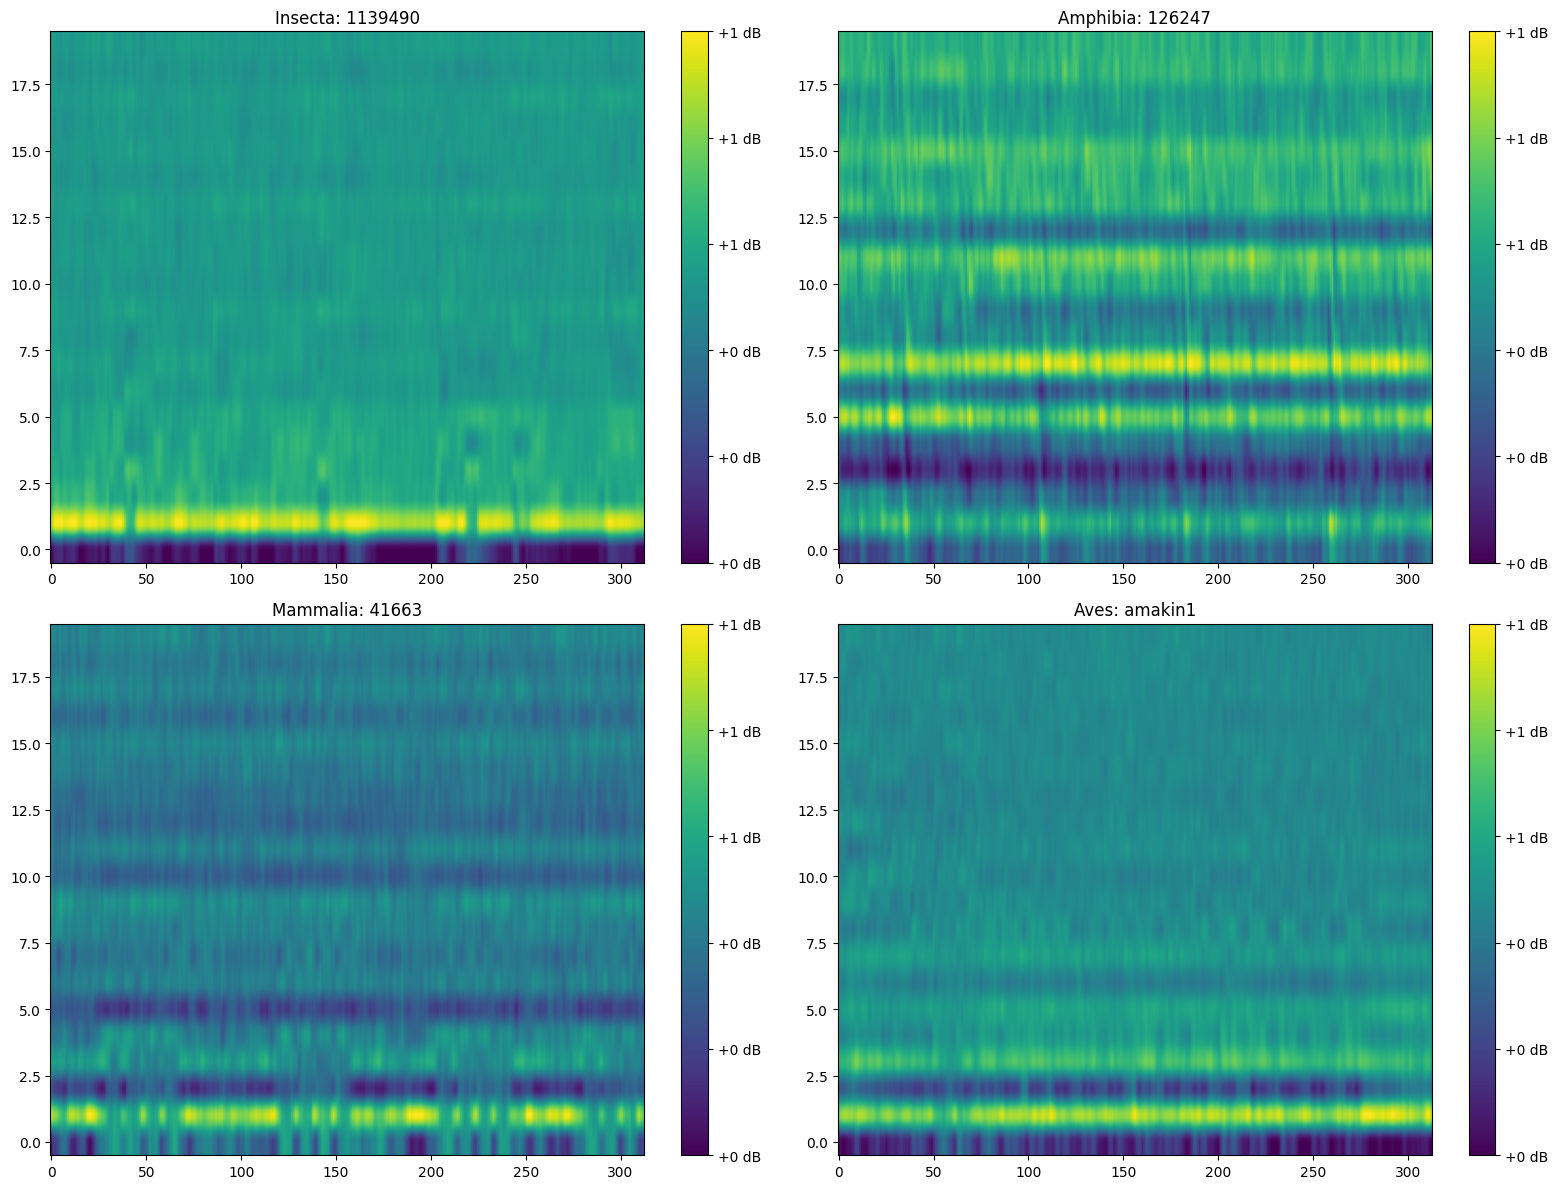

In [6]:
# Instantiate configuration
cfg = CFG()

# Logging basic configuration info
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if cfg.debug else 'FULL MODE - Processing all samples'}")

# Start timer
start_time = time.time()

# Print debug setting
print(f"Debug mode: {'ON' if cfg.debug else 'OFF'}")
print(f"Max samples to process: {cfg.N_MAX if cfg.N_MAX is not None else 'ALL'}")

# Load taxonomy mapping: primary label to human-readable class name
print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

# Load training metadata: includes labels and filenames
print("Loading training metadata...")
train_df = pd.read_csv(cfg.train_csv)

# Create mappings from label to numeric ID and vice versa
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')

# Create a working dataframe with essential columns and paths
working_df = train_df[['primary_label', 'rating', 'filename']].copy()

# Map label to numeric target ID
working_df['target'] = working_df.primary_label.map(label2id)

# Construct full filepath to audio file
working_df['filepath'] = cfg.train_datadir + '/' + working_df.filename

# Generate a unique sample name using folder name and file basename
working_df['samplename'] = working_df.filename.map(
    lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0]
)

# Map primary label to its readable class name
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))

# Limit the number of samples to process if in debug mode
total_samples = min(len(working_df), cfg.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')

# Print number of samples per class
print(f'Samples by class:')
print(working_df['class'].value_counts())

# Generate mfcc spectrograms from audio files
all_bird_data = generate_spectrograms(working_df, cfg)

# Visualize and save sample spectrograms
plot_mfccspec_examples(working_df, cfg, all_bird_data)

In [7]:
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for key, value in mfccs.items():
        value = value.T
        tmp = value[1:] - value[0:-1]
        dm = np.hstack((value[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs
train_dmfccs = compute_delta_mfccs(all_bird_data)
# put dmfccs from all training data together
all_dmfccs = np.vstack(train_dmfccs)
print(all_dmfccs.shape)
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
km.cluster_centers_

# ADD K-MEANS SAVE CODE HERE:
joblib.dump(km, '/kaggle/working/kmeans_model.joblib')
print("K-means model saved to: /kaggle/working/kmeans_model.joblib")

(8911968, 40)
K-means model saved to: /kaggle/working/kmeans_model.joblib


In [8]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = np.zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = np.bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows
train_bow = bow_transform(km, train_dmfccs)

In [9]:
# convert list of tags into binary class labels
def tags2class(working_df):
    b = np.zeros(shape=(len(working_df), len(working_df.target.unique())))
    for i,t in enumerate(working_df.target):
        b[i,t] = 1
    return b
train_classes = tags2class(working_df)

In [10]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
# test_Xtf  = tf_trans.transform(test_bow)

# ADD TF-IDF SAVE CODE HERE:
joblib.dump(tf_trans, '/kaggle/working/tfidf_transformer.joblib')
print("TF-IDF transformer saved to: /kaggle/working/tfidf_transformer.joblib")

TF-IDF transformer saved to: /kaggle/working/tfidf_transformer.joblib


In [11]:
tagmodels = {}
for i,t in enumerate(working_df.target.unique()):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=np.logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

# ADD LOGISTIC REGRESSION MODELS SAVE CODE HERE:
joblib.dump(tagmodels, '/kaggle/working/lr_models.joblib')
print("Logistic Regression models saved to: /kaggle/working/lr_models.joblib")

training 0 - 0
training 1 - 1
training 2 - 2
training 3 - 3
training 4 - 4
training 5 - 5
training 6 - 6
training 7 - 7
training 8 - 8
training 9 - 9
training 10 - 10
training 11 - 11
training 12 - 12
training 13 - 13
training 14 - 14
training 15 - 15
training 16 - 16
training 17 - 17
training 18 - 18
training 19 - 19
training 20 - 20
training 21 - 21
training 22 - 22
training 23 - 23
training 24 - 24
training 25 - 25
training 26 - 26
training 27 - 27
training 28 - 28
training 29 - 29
training 30 - 30
training 31 - 31
training 32 - 32
training 33 - 33
training 34 - 34
training 35 - 35
training 36 - 36
training 37 - 37
training 38 - 38
training 39 - 39
training 40 - 40
training 41 - 41
training 42 - 42
training 43 - 43
training 44 - 44
training 45 - 45
training 46 - 46
training 47 - 47
training 48 - 48
training 49 - 49
training 50 - 50
training 51 - 51
training 52 - 52
training 53 - 53
training 54 - 54
training 55 - 55
training 56 - 56
training 57 - 57
training 58 - 58
training 59 - 59


In [12]:
train_predscore = np.zeros(shape=(len(train_dmfccs), len(working_df.target.unique())))

for i,t in enumerate(working_df.target.unique()):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

predicting 0 - 0
predicting 1 - 1
predicting 2 - 2
predicting 3 - 3
predicting 4 - 4
predicting 5 - 5
predicting 6 - 6
predicting 7 - 7
predicting 8 - 8
predicting 9 - 9
predicting 10 - 10
predicting 11 - 11
predicting 12 - 12
predicting 13 - 13
predicting 14 - 14
predicting 15 - 15
predicting 16 - 16
predicting 17 - 17
predicting 18 - 18
predicting 19 - 19
predicting 20 - 20
predicting 21 - 21
predicting 22 - 22
predicting 23 - 23
predicting 24 - 24
predicting 25 - 25
predicting 26 - 26
predicting 27 - 27
predicting 28 - 28
predicting 29 - 29
predicting 30 - 30
predicting 31 - 31
predicting 32 - 32
predicting 33 - 33
predicting 34 - 34
predicting 35 - 35
predicting 36 - 36
predicting 37 - 37
predicting 38 - 38
predicting 39 - 39
predicting 40 - 40
predicting 41 - 41
predicting 42 - 42
predicting 43 - 43
predicting 44 - 44
predicting 45 - 45
predicting 46 - 46
predicting 47 - 47
predicting 48 - 48
predicting 49 - 49
predicting 50 - 50
predicting 51 - 51
predicting 52 - 52
predicting 53

In [13]:
# plot an ROC curve using class labels and class scores
from sklearn import metrics 
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at these points
    all_fpr = np.unique(np.concatenate(fprall))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += np.interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = np.mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.grid(True)

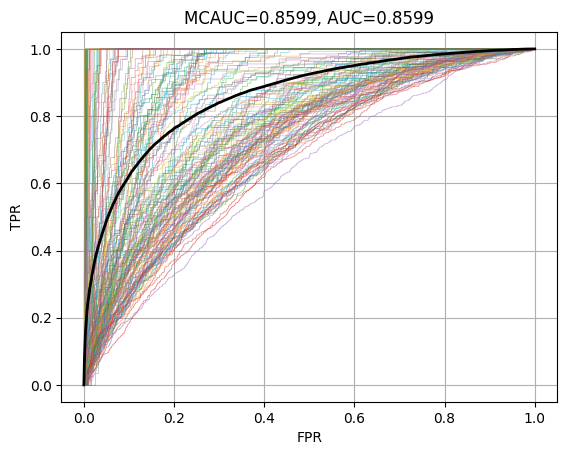

In [14]:
plot_roc(working_df.target.unique(), train_classes, train_predscore)